In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Load the data
X_train = pd.read_csv('hubert_features_train_3.csv').values  # Load train features from CSV
X_test = pd.read_csv('hubert_features_test_3.csv').values  # Load test features from CSV
y_train = pd.read_csv('y_train_age_group.csv')  # CSV containing Age, Gender, and Age_Group columns
y_test = pd.read_csv('y_test_age_group.csv')

# Convert gender labels to binary (m -> 0, f -> 1)
y_train['Gender'] = y_train['Gender'].map({'m': 0, 'f': 1})
y_test['Gender'] = y_test['Gender'].map({'m': 0, 'f': 1})

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Function to build the CNN model
def build_model(input_shape, num_classes):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(32, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv1D(128, kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes))  # Output layer for regression or binary classification
    return model

# Filter and evaluate based on Age Group
age_groups = ['4-6', '7-9', '10-14']

for group in age_groups:
    # Filter train and test data for the current age group
    train_group = y_train[y_train['Age_Group'] == group]
    test_group = y_test[y_test['Age_Group'] == group]
    
    X_train_group = X_train[train_group.index].reshape(-1, 1024, 1)  # Reshape for Conv1D
    X_test_group = X_test[test_group.index].reshape(-1, 1024, 1)
    
    y_train_age = train_group['Age'].values
    y_test_age = test_group['Age'].values
    
    y_train_gender = train_group['Gender'].values
    y_test_gender = test_group['Gender'].values
    
    # Build and compile models
    model_age = build_model((1024, 1), 1)  # Regression for age
    model_gender = build_model((1024, 1), 1)  # Binary classification for gender

    model_age.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    model_gender.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train models
    model_age.fit(X_train_group, y_train_age, epochs=50, batch_size=32, verbose=1)
    model_gender.fit(X_train_group, y_train_gender, epochs=50, batch_size=32, verbose=1)

    # Evaluate age prediction
    y_pred_age = model_age.predict(X_test_group).flatten()
    age_accuracy = accuracy_score(np.round(y_test_age), np.round(y_pred_age))

    # Evaluate gender prediction
    y_pred_gender = model_gender.predict(X_test_group).flatten()
    y_pred_gender = (y_pred_gender > 0.5).astype(int)  # Convert logits to binary class
    gender_accuracy = accuracy_score(y_test_gender, y_pred_gender)

    # Print results
    print(f"\nAge Group: {group}")
    print(f"Age classification accuracy: {age_accuracy * 100:.2f}%")
    print(f"Gender classification accuracy: {gender_accuracy * 100:.2f}%")
    
    # Classification Reports
    print("\nAge Classification Report:")
    age_report = classification_report(np.round(y_test_age), np.round(y_pred_age), output_dict=True)
    print(classification_report(np.round(y_test_age), np.round(y_pred_age)))

    print("\nGender Classification Report:")
    gender_report = classification_report(y_test_gender, y_pred_gender, output_dict=True)
    print(classification_report(y_test_gender, y_pred_gender))
    
    # Individual accuracies for age
    print("\nIndividual Age Accuracies:")
    for age in np.unique(y_test_age):
        age_count = np.sum(y_test_age == age)
        correct_count = np.sum(np.round(y_pred_age)[y_test_age == age])
        individual_age_accuracy = correct_count / age_count * 100 if age_count > 0 else 0
        print(f"Age {age}: {individual_age_accuracy:.2f}%")

    # Individual accuracies for gender
    cm_gender = confusion_matrix(y_test_gender, y_pred_gender)
    gender_accuracies = {
        'm': cm_gender[0, 0] / (cm_gender[0, 0] + cm_gender[0, 1]) * 100,
        'f': cm_gender[1, 1] / (cm_gender[1, 0] + cm_gender[1, 1]) * 100
    }
    print("\nIndividual Gender Accuracies:")
    for gender, accuracy in gender_accuracies.items():
        print(f"Gender {gender}: {accuracy:.2f}%")


/home/mojo/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1730403314.982287   27335 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-01 01:05:15.124542: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your 

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 411ms/step - loss: 63745.1484 - mae: 143.1789
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step - loss: 1131.8251 - mae: 19.2539
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 439ms/step - loss: 392.0332 - mae: 13.2365
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 447ms/step - loss: 2641.5396 - mae: 19.4820
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - loss: 924.0043 - mae: 13.6430
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 449ms/step - loss: 1241.7662 - mae: 16.0620
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 468ms/step - loss: 646.1232 - mae: 12.5707
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 459ms/step - loss: 187.0157 - mae: 7.0601
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - loss: 29.6559 - mae: 4.5463
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step - loss: 19.9440 - mae: 3.8096
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 443ms/step - loss: 25.4812 - mae: 3.2987
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - loss: 39.0665 - mae: 2.9409
Epoch 13/50
3/3 

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMet

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 460ms/step - loss: 5259.9492 - mae: 43.2068
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 462ms/step - loss: 4318.0513 - mae: 25.3123
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 458ms/step - loss: 435.0567 - mae: 13.8457
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 458ms/step - loss: 86.0921 - mae: 5.2959
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 479ms/step - loss: 8.7720 - mae: 2.2562
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 478ms/step - loss: 3.8350 - mae: 1.4701
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step - loss: 2.1781 - mae: 1.0610
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 497ms/step - loss: 1.1744 - mae: 0.8011
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 494ms/step - loss: 0.6593 - mae: 0.5936
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 486ms/step - loss: 0.7360 - mae: 0.5636
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 476ms/step - loss: 0.5287 - mae: 0.5352
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 476ms/step - loss: 0.5129 - mae: 0.4860
Epoch 13/50
1

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Reca

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 492ms/step - loss: 4238.7808 - mae: 40.7760
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 505ms/step - loss: 14881.8574 - mae: 24.8239
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 497ms/step - loss: 885.1128 - mae: 14.4199
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 494ms/step - loss: 458.1960 - mae: 9.4706
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 494ms/step - loss: 33.6049 - mae: 3.5469
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 490ms/step - loss: 38.6163 - mae: 2.6866
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 503ms/step - loss: 9.3015 - mae: 1.7525
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 503ms/step - loss: 7.5197 - mae: 1.2883
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 502ms/step - loss: 6.6341 - mae: 1.2537
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 520ms/step - loss: 10.1857 - mae: 1.4188
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 545ms/step - loss: 3.6485 - mae: 1.0487
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 519ms/step - loss: 5.3898 - mae: 1.1906
Epoch 13

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Reca

SVM Accuracy: 0.9457
SVM Classification Report:
              precision    recall  f1-score   support

         4-6       0.95      0.94      0.94        62
         7-9       1.00      0.93      0.96        14
       10-14       0.93      0.96      0.94        53

    accuracy                           0.95       129
   macro avg       0.96      0.94      0.95       129
weighted avg       0.95      0.95      0.95       129



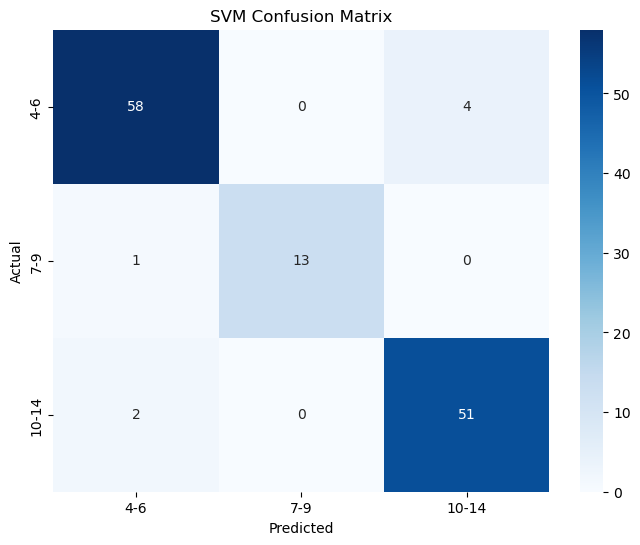

Epoch 1/50


/home/mojo/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 482ms/step - accuracy: 0.5902 - loss: 2.9772 - val_accuracy: 0.7907 - val_loss: 0.5443
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 479ms/step - accuracy: 0.9399 - loss: 0.1706 - val_accuracy: 0.8430 - val_loss: 0.4744
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 478ms/step - accuracy: 0.9919 - loss: 0.0494 - val_accuracy: 0.8023 - val_loss: 0.6290
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 475ms/step - accuracy: 0.9982 - loss: 0.0097 - val_accuracy: 0.8430 - val_loss: 0.6290
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 478ms/step - accuracy: 0.9947 - loss: 0.0142 - val_accuracy: 0.8372 - val_loss: 0.5286
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 480ms/step - accuracy: 0.9995 - loss: 0.0067 - val_accuracy: 0.8140 - val_loss: 0.6991
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 481ms/step - accuracy: 0.9989 - loss: 0.0048 - val_accuracy: 0.7035 - val_loss: 1.1182
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 478ms/step - accuracy: 0.9999 - loss: 0.0014 - val_accuracy: 0.796

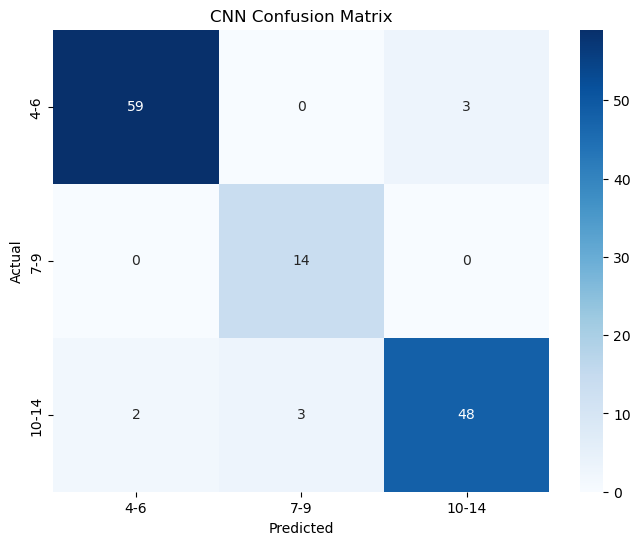

Epoch 1/50


/home/mojo/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6214 - loss: 1.1221 - val_accuracy: 0.7442 - val_loss: 0.5972
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7904 - loss: 0.6671 - val_accuracy: 0.7616 - val_loss: 0.6135
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8604 - loss: 0.3531 - val_accuracy: 0.8430 - val_loss: 0.4576
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8920 - loss: 0.2979 - val_accuracy: 0.7384 - val_loss: 0.6894
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9073 - loss: 0.2201 - val_accuracy: 0.7907 - val_loss: 0.6292
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9593 - loss: 0.1064 - val_accuracy: 0.7907 - val_loss: 0.7079
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9719 - loss: 0.0732 - val_accuracy: 0.7384 - val_loss: 0.9476
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9613 - loss: 0.1120 - val_accuracy: 0.7384 - val_loss: 0.9166
Epo

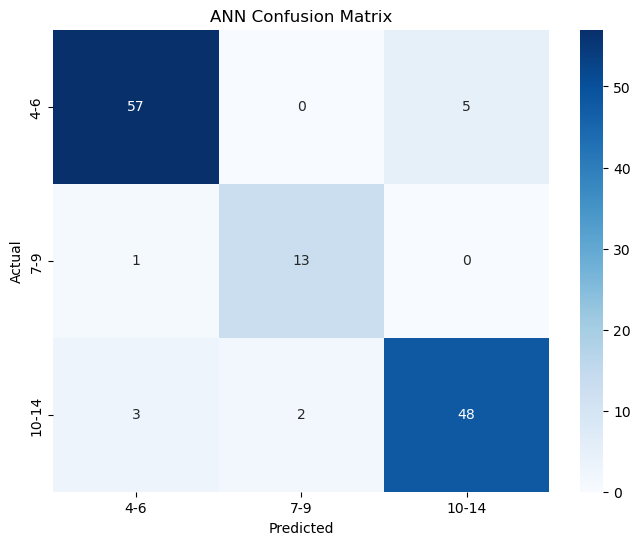

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
train_features = pd.read_csv('hubert_features_train_3.csv')
test_features = pd.read_csv('hubert_features_test_3.csv')

# Read Age labels instead of Gender
train_labels = pd.read_csv('y_train_age_group.csv').Age_Group
test_labels = pd.read_csv('y_test_age_group.csv').Age_Group

# Encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Ensure that the order of the labels is maintained in the encoded data
label_order = ['4-6', '7-9', '10-14']

# Handle unseen labels in test set by filtering out labels not present in train set
test_labels_filtered = test_labels[test_labels.isin(train_labels.unique())]
test_features_filtered = test_features[test_labels.isin(train_labels.unique())]
test_labels_encoded = label_encoder.transform(test_labels_filtered)

# Standardize features
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features)
test_features_normalized = scaler.transform(test_features_filtered)

# Function to plot confusion matrix with fixed order
def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# SVM model
svm_model = SVC(kernel='linear', C=10.0, gamma='scale', random_state=42)
svm_model.fit(train_features_normalized, train_labels_encoded)

# SVM Prediction and Evaluation
svm_predictions = svm_model.predict(test_features_normalized)
svm_accuracy = accuracy_score(test_labels_encoded, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("SVM Classification Report:")
print(classification_report(test_labels_encoded, svm_predictions, target_names=label_order))

# Confusion Matrix for SVM
cm_svm = confusion_matrix(test_labels_encoded, svm_predictions)
plot_confusion_matrix(cm_svm, label_order, "SVM")

# CNN model (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

# Reshape for CNN input
train_features_cnn = np.expand_dims(train_features_normalized, axis=-1)  # Shape: (num_samples, 1024, 1)
test_features_cnn = np.expand_dims(test_features_normalized, axis=-1)    # Shape: (num_samples, 1024, 1)

cnn_model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(1024, 1)),  # Updated input shape to 1024
    Conv1D(128, kernel_size=5, activation='relu'),
    Conv1D(256, kernel_size=5, activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(train_features_cnn, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

# CNN Prediction and Evaluation
cnn_predictions = np.argmax(cnn_model.predict(test_features_cnn), axis=-1)
cnn_accuracy = accuracy_score(test_labels_encoded, cnn_predictions)
print(f"CNN Accuracy: {cnn_accuracy:.4f}")
print("CNN Classification Report:")
print(classification_report(test_labels_encoded, cnn_predictions, target_names=label_order))

# Confusion Matrix for CNN
cm_cnn = confusion_matrix(test_labels_encoded, cnn_predictions)
plot_confusion_matrix(cm_cnn, label_order, "CNN")

# ANN model (TensorFlow)
ann_model = Sequential([
    Dense(512, activation='relu', input_shape=(1024,)),  # Updated input shape to 1024
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ann_model.fit(train_features_normalized, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

# ANN Prediction and Evaluation
ann_predictions = np.argmax(ann_model.predict(test_features_normalized), axis=-1)
ann_accuracy = accuracy_score(test_labels_encoded, ann_predictions)
print(f"ANN Accuracy: {ann_accuracy:.4f}")
print("ANN Classification Report:")
print(classification_report(test_labels_encoded, ann_predictions, target_names=label_order))

# Confusion Matrix for ANN
cm_ann = confusion_matrix(test_labels_encoded, ann_predictions)
plot_confusion_matrix(cm_ann, label_order, "ANN")

# PyTorch CNN Model
import torch
from torch.utils.data import DataLoader, TensorDataset

# Prepare PyTorch tensors
X_train_tensor = torch.tensor(train_features_cnn, dtype=torch.float32).permute(0, 2, 1)  # Shape: (num_samples, 1, 1024)
y_train_tensor = torch.tensor(train_labels_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(test_features_cnn, dtype=torch.float32).permute(0, 2, 1)    # Shape: (num_samples, 1, 1024)
y_test_tensor = torch.tensor(test_labels_encoded, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

import torch.nn as nn
import torch.optim as optim

class CNN1DModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 1024, 512)  # Updated to 1024 features
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

input_channels = 1
num_classes = len(label_order)
model = CNN1DModel(input_channels, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop and evaluation (you can add this part here for PyTorch training)
